In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import tqdm
import torch
import random
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

from vae.cvae import RnnVae
from cupy.cuda import Device
from sklearn.datasets.lfw import Bunch
from torch.nn.utils import clip_grad_norm_
from vae.corpus import PandasDataset, OneHotCorpus
from vae.metrics import diversity, validity, uniqueness
from vae.misc import KLAnnealer, CosineAnnealingLRWithRestart, Logger, LogPlotter

In [4]:
!nvidia-smi

Thu Jun 21 17:44:02 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 37%   64C    P2    91W / 250W |   8119MiB / 11172MiB |     50%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 55%   75C    P0    64W / 250W |     19MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [5]:
args = Bunch(
    # Model
    model=Bunch(
        q=Bunch(
            cell='gru',
            bidir=True,
            d_h=64,
            n_layers=1,
            r_dropout=0.0,  # should be around 0 to help encoder train more easily
            s_dropout=0.0  # same as `r_dropout`
        ),
        g=Bunch(
            cell='gru',
            n_layers=2,
            r_dropout=0.0,
            s_dropout=0.0
        ),
        d_z=64,
        freeze_embeddings=False
    ),
    # Train
    train=Bunch(
        n_batch=128,
        grad_clipping=10,
        kl=Bunch(  # kl weight annealing params
            i_start=1,
            w_start=0.01,
            w_max=0.1
        ),
        lr=Bunch(
            value=1e-2,  # from `lr`
            scheduler=Bunch(
                n_period=5,  # n_epoch for first restart
                n_r=1,  # number of restarts in SGDR
                n_mult=1,
                lr_min=1e-3  # to `lr`
            )
        )
    ),
    # Env
    device_code=1
)

In [6]:
device = torch.device(
    f'cuda:{args.device_code}' 
    if args.device_code >= 0 and torch.cuda.is_available()
    else 'cpu'
)
device

device(type='cuda', index=1)

In [7]:
data_path = '/media/Molecules/molecules.csv'
n_train, n_val = 1_000_000, 100_000

%time data = pd.read_csv(data_path, usecols=['SMILES'])
data = data.sample(n_train + n_val)

train, val = data[:n_train], data[n_train: n_train + n_val]
train, val = PandasDataset(train), PandasDataset(val)
len(train), len(val)

CPU times: user 13.7 s, sys: 820 ms, total: 14.5 s
Wall time: 14.5 s


(1000000, 100000)

In [8]:
corpus = OneHotCorpus(args.train.n_batch, device)
train = corpus.fit_transform(train)
# val = corpus.transform(val)
ds_val = val  # dataset

In [9]:
model = RnnVae(**args.model, x_vocab=corpus.vocab).to(device)
model

RnnVae(
  (x_emb): Embedding(36, 36, padding_idx=9)
  (encoder_rnn): GRU(36, 64, batch_first=True, bidirectional=True)
  (q_mu): Linear(in_features=128, out_features=64, bias=True)
  (q_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder_rnn): GRU(100, 64, num_layers=2, batch_first=True)
  (decoder_fc): Linear(in_features=64, out_features=36, bias=True)
  (encoder): ModuleList(
    (0): GRU(36, 64, batch_first=True, bidirectional=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): ModuleList(
    (0): GRU(100, 64, num_layers=2, batch_first=True)
    (1): Linear(in_features=64, out_features=36, bias=True)
  )
  (vae): ModuleList(
    (0): Embedding(36, 36, padding_idx=9)
    (1): ModuleList(
      (0): GRU(36, 64, batch_first=True, bidirectional=True)
      (1): Linear(in_features=128, out_features=64, bias=True)
      (2): Linear(in_features=128, out_features=64, bias=True)


In [10]:
# Sanity check
x = next(iter(train))
kl_loss, recon_loss = model(x)
sampled_x = corpus.reverse(model.sample_sentence(1, 100)[-1])[0]
print(f"kl_loss={kl_loss:.2f} recon_loss={recon_loss:.2f} \nsampled_x='{sampled_x}`'")

kl_loss=0.21 recon_loss=3.62 
sampled_x='5](Nc)6P+B66#lnO8BF8`'


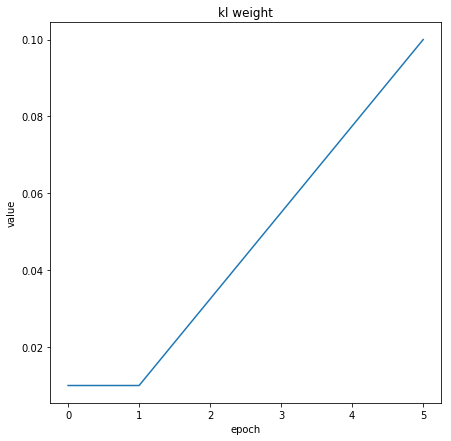

In [11]:
n_epoch = sum(args.train.lr.scheduler.n_period * (args.train.lr.scheduler.n_mult ** i)
              for i in range(args.train.lr.scheduler.n_r))
kl_annealer = KLAnnealer(**args.train.kl, n_epoch=n_epoch)
xs = np.linspace(0, n_epoch, num=n_epoch + 1)
ts = np.array([kl_annealer(i) for i in xs])
plt.figure(figsize=(7, 7))
plt.ylabel('value')
plt.xlabel('epoch')
plt.title('kl weight')
plt.plot(xs, ts);

In [12]:
get_params = lambda: (p for p in model.vae.parameters() if p.requires_grad)
trainer = optim.Adam(get_params(), lr=args.train.lr.value)
lr_scheduler = CosineAnnealingLRWithRestart(trainer, **args.train.lr.scheduler)

In [ ]:
model.train()
T = tqdm.tqdm_notebook(range(n_epoch))
n_iter, n_last = len(train), 1000
elog, ilog = Logger(), Logger()

for epoch in T:
    # Epoch start
    kl_weight = kl_annealer(epoch)
    
    # Iters
    for i, x in enumerate(train):
        # Forward
        kl_loss, recon_loss = model(x)
        loss = kl_weight * kl_loss + recon_loss
        
        # Backward
        trainer.zero_grad()
        loss.backward()
        clip_grad_norm_(get_params(), args.train.grad_clipping)
        trainer.step()
        
        # Log
        lr = trainer.param_groups[0]['lr']
        ilog.append({
            'epoch': epoch,
            'kl_loss': kl_loss.item(),
            'recon_loss': recon_loss.item(),
            'loss': loss.item(),
            'kl_weight': kl_weight,
            'lr': lr
        })
        
        # Update T
        kl_loss_value = np.mean(ilog['kl_loss'][-n_last:])
        recon_loss_value = np.mean(ilog['recon_loss'][-n_last:])
        loss_value = np.mean(ilog['loss'][-n_last:])
        postfix_strs = []
        postfix_strs.append(f'i={i}/{n_iter}')
        postfix_strs.append(f'kl_loss={kl_loss_value:.5f}')
        postfix_strs.append(f'recon_loss={recon_loss_value:.5f}')
        postfix_strs.append(f'loss={loss_value:.5f}')
        postfix_strs.append(f'klw={kl_weight:.3f} lr={lr:.5f}')
        T.set_postfix_str(' '.join(postfix_strs))
        T.refresh()
    
    # Log
    sent = corpus.reverse(model.sample_sentence(1, 100)[-1])[0]
    elog.append({
        **{k: v for k, v in ilog[-1].items() if 'loss' not in k},
        'kl_loss': kl_loss_value,
        'recon_loss': recon_loss_value,
        'loss': loss_value,
        'sent': sent
    })
    
    # Print result
    print(f"[epoch={epoch}]: '{sent}'")
    
    # Epoch end
    lr_scheduler.step()

[epoch=0]: 'CC(C)COc1cccc(-c2n[nH]c(c32)c1'
[epoch=1]: 'COC(C)Cc1nccs1'


In [ ]:
plotter = LogPlotter(elog)
plotter.grid([
    'kl_loss', 'recon_loss',
    'loss', 'lr'
])

In [ ]:
# Same as Oktai
def test_model(dataset, n_gen=1000, n_other=1000):
    gen_smiles = []
    for _ in tqdm.tqdm_notebook(range(n_gen // 100)):
        gen_smiles.extend(corpus.reverse(model.sample_sentence(100, 100)[-1]))
        
    other_smiles = random.sample(list(dataset), n_other)

    internal_diversity_val = diversity(gen_smiles)
    external_diversity_val = diversity(gen_smiles, other_smiles)  # TODO: check it
    validity_val = validity(gen_smiles)
    uniqueness_val = uniqueness(gen_smiles)

    print('\n###########################')
    print('Internal Diversity = {}'.format(internal_diversity_val))
    print('External Diversity = {}'.format(external_diversity_val))
    print('Validity = {}'.format(validity_val))
    print('Uniqueness = {}'.format(uniqueness_val))
    print('############################\n')

In [ ]:
test_model(ds_val)

In [ ]:
path = Bunch(save='vae.pt')
torch.save((args, model), path.save)
!du -sh {path.save}